# 3. Overexpression

### Import libraries:

In [124]:
# First, we can import some functions so we can use the model
from cobra.io import read_sbml_model, write_sbml_model
from cobra import Reaction, Metabolite
import matplotlib.pyplot as plt
from cobra.flux_analysis import production_envelope

### Read model:

In [125]:
# Second, we can read the GEM and save it as ‘model’
model = read_sbml_model('data/iML1515_het.xml')

## pha pathway

    · ENZYME 1: Reaction ACACT1r is already present in E.coli. Enzyme EC 2.3.1.9 - acetyl-CoA C-acetyltransferase catalyses the Claisen condensation of an acetyl-CoA and an acyl-CoA (often another acetyl-CoA), leading to the formation of an acyl-CoA. Km = 0.14 mM; Turnover number = 6.5 1/s per mg of protein.

    · ENZYME 2: EC 1.1.1.36 - acetoacetyl-CoA reductase (HACD1) calready present in E.coli and catalyzes the chiral reduction of acetoacetyl-CoA to (R)-3-hydroxybutyryl-CoA. Km = 0.002 mM; Turnover number = 90 1/s per mg of protein.

    · ENZYME 3: EC 2.3.1.304 - poly-(R)-3-hydroxyalkanoate polymerase (phaC) coming from Cupriavidus necator which polymerizes (R)-3-hydroxybutyryl-CoA to create polyhydroxybutyrate (PHB). Km = 0.32 mM; Turnover number = 44 1/s per mg of protein.

Because we cannot use OptGene to determine which genes to overexpress and thus increase P3HB production, we decided to base the overexpression assay based on the properties of the enzymes. In the sublot of production enzymes, the overexpressed gene is the one corresponding to the ACACT1r reaction.

The bottleneck in a metabolic pathway is typically determined by the slowest step, which is often associated with the enzyme that has the lowest turnover number. The turnover number, also known as kcat (catalytic constant), represents the number of substrate molecules converted to product per unit time by a single enzyme molecule.

The turnover number for Enzyme 1 is significantly lower than the turnover numbers for other two enzymes. This means that Enzyme 1 processes substrate molecules at a slower rate compared to the other enzymes in the pathway. As a result, Enzyme 1 becomes the bottleneck because it limits the overall rate of the pathway. Therefore is the main objective for this sublot.

FROM A BIOLOGICAL POINT OF VIEW.

In [126]:
with model:
    # We change the media to acetate:
    acetate_medium = model.medium
    acetate_medium['EX_glc__D_e'] = 0
    acetate_medium['EX_ac_e'] = 10
    model.medium = acetate_medium
    
    # Basal values:
    solution = model.optimize()
    growth = solution.objective_value
    
    # Set bounds of biomass inside with model, therefore can be changed for simulation
    model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = 0.78 * solution.objective_value
    model.reactions.BIOMASS_Ec_iML1515_core_75p37M.upper_bound = solution.objective_value    # Max value will always be the optimal value reachable
    
    # Let's retrieve the basal fluxes of this reactions
    aacoa_c_flux = solution.fluxes["ACACT1r"]
    flux_summary1 = model.metabolites.aacoa_c.summary()
    print(f"Basal ACACT1r (aacoa_c) flux: {round(flux_summary1.to_frame().loc['ACACT1r', 'flux'],4)}")
    O1_ACACT1r_basal = round(flux_summary1.to_frame().loc['ACACT1r', 'flux'],4)    # storing info for later
    
    # Let's evaluate growth reduciton vs overexpression factor:
    growth_reduction_values = []
    overexpression_factor_values = []
    for i in range(1, 10):
        model.reactions.ACACT1r.lower_bound = aacoa_c_flux * i
        growth_overexpression = model.slim_optimize()

        growth_reduction = (growth - growth_overexpression)/growth*100
        if i == 2:
            O1_growth_red = growth_reduction
        
        growth_reduction_values.append(growth_reduction)
        overexpression_factor_values.append(i)
        
    # Output of 2-fold overexpression
    print(f"\nBasal growth: {round(growth,4)}")
    print(f"Growth reduction: {round(O1_growth_red, 4)}")
    O1_growth_red = round(O1_growth_red, 4)    # storing info for later
    print(f"\nACACT1r (aacoa_c) flux overexpression: {round(flux_summary1.to_frame().loc['ACACT1r', 'flux'] * 2, 4)}")
    O1_ACACT1r_overexpression = round(flux_summary1.to_frame().loc['ACACT1r', 'flux'] * 2, 4)    # storing info for later


Basal ACACT1r (aacoa_c) flux: 0.0748

Basal growth: 0.2101
Growth reduction: 4.0187

ACACT1r (aacoa_c) flux overexpression: 0.1495


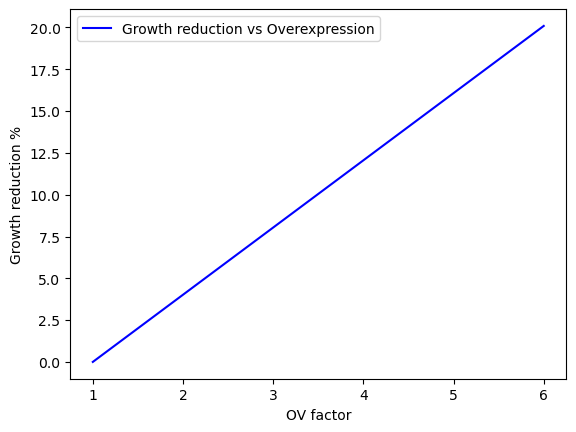

In [127]:
plt.plot(overexpression_factor_values, growth_reduction_values, color='blue', linestyle='-', marker='', markersize=2, label='Growth reduction vs Overexpression')

# Add labels and title
plt.ylabel('Growth reduction %')
plt.xlabel('OV factor')

# Show the plot
plt.legend()
plt.show()

## Acetate uptake enzymes

    · ENZYME 1: Reaction ACKr is already present in E.coli. EC 2.7.2.1 - acetate kinase - Catalyzes the formation of acetyl phosphate from acetate and ATP. Can also catalyze the reverse reaction. During anaerobic growth of the organism, this enzyme is also involved in the synthesis of most of the ATP formed catabolically. Km = 0.67 mM; Turnover number = 908 1/s per mg of protein.

    · ENZYME 2: Reaction PTAr is already present in E.coli. EC 2.3.1.8 - phosphate acetyltransferase - Catalyzes the reversible interconversion of acetyl-CoA and acetyl phosphate. On minimal medium acetyl-CoA is generated. In rich medium acetyl-CoA is converted to acetate and allowing the cell to dump the excess of acetylation potential in exchange for energy in the form of ATP. Km = 0.045 mM; Turnover number = 29.6 1/s per mg of protein.
    
The lower turnover number of PTAr indicates that it processes the substrate at a slower rate compared to ACKr. Therefore, overexpressing PTAr can potentially alleviate the bottleneck and increase the overall flux through the pathway, leading to higher production of the desired product.

In [128]:
with model:

    # We change the media to acetate:
    acetate_medium = model.medium
    acetate_medium['EX_glc__D_e'] = 0
    acetate_medium['EX_ac_e'] = 10
    model.medium = acetate_medium
    
    # Basal values:
    solution = model.optimize()
    growth = solution.objective_value
    accoa_c_flux = solution.fluxes["PTAr"]
    
    # Set bounds of biomass inside with model, therefore can be changed for simulation
    model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = 0.78 * solution.objective_value
    model.reactions.BIOMASS_Ec_iML1515_core_75p37M.upper_bound = solution.objective_value    # Max value will always be the optimal value reachable
    
    # Let's retrieve the basal fluxes of this reactions
    flux_summary1 = model.metabolites.accoa_c.summary()
    print(f"PTAr (accoa_c) flux before setting objective: {round(flux_summary1.to_frame().loc['PTAr', 'flux'],4)}")
    O2_PTAr_basal = round(flux_summary1.to_frame().loc['PTAr', 'flux'],4)    # storing info for later
    
    # Let's evaluate growth reduciton vs overexpression factor:
    growth_reduction_values = []
    overexpression_factor_values = []
    for i in range(1, 10):
        model.reactions.PTAr.lower_bound = accoa_c_flux * i
        solution_overexpression = model.optimize()
        growth_overexpression = solution_overexpression.objective_value

        growth_reduction = (growth - growth_overexpression)/growth*100
        if i == 2:
            O2_growth_red = growth_reduction
        
        growth_reduction_values.append(round(growth_reduction,4))
        overexpression_factor_values.append(i)
    
    print(f"\nBasal growth: {round(growth,4)}")
    print(f"Growth reduction: {round(O2_growth_red,4)}")
    O2_growth_red = round(O2_growth_red,4)    # storing info for later
    print(f"\nPTAr (aacoa_c) flux overexpression: {round(flux_summary1.to_frame().loc['PTAr', 'flux'] * 2,4)}")
    O2_PTAr_overexpression = round(flux_summary1.to_frame().loc['PTAr', 'flux'] * 2,4)    # storing info for later

PTAr (accoa_c) flux before setting objective: 10.1223

Basal growth: 0.2101
Growth reduction: 0.0

PTAr (aacoa_c) flux overexpression: 20.2446


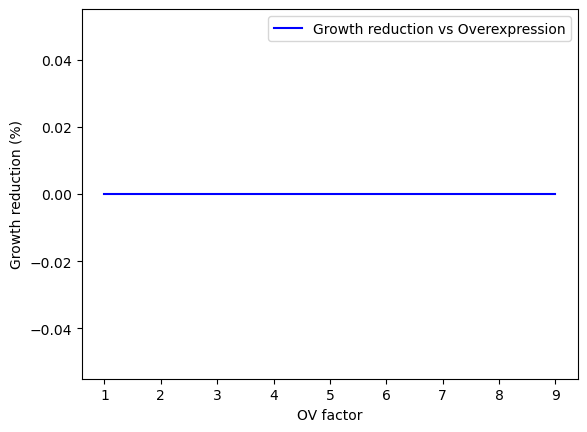

In [129]:
plt.plot(overexpression_factor_values, growth_reduction_values, color='blue', linestyle='-', marker='', markersize=2, label='Growth reduction vs Overexpression')

# Add labels and title
plt.ylabel('Growth reduction (%)')
plt.xlabel('OV factor')

# Show the plot
plt.legend()
plt.show()

Apparently, the overexpression on PTAr doesn't have any negative effect on the biomass production. Therefore we can overexpress the gene as much as needed, therefore avoid the bottleneck generated by the reaction itself.

## Combination of both overexpressions:

In [130]:
with model:
    # We change the media to acetate:
    acetate_medium = model.medium
    acetate_medium['EX_glc__D_e'] = 0
    acetate_medium['EX_ac_e'] = 10
    model.medium = acetate_medium
    
    # Basal values:
    solution = model.optimize()
    growth = solution.objective_value
    
    #Set bounds of biomass inside with model, therefore can be changed for simulation
    model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = 0.78 * solution.objective_value
    model.reactions.BIOMASS_Ec_iML1515_core_75p37M.upper_bound = solution.objective_value    #Max value will always be the optimal value reachable
    
    #Before setting the new objective we have to look to basal fluxes of this reactions
    flux_summary1 = model.metabolites.aacoa_c.summary()
    flux_summary2 = model.metabolites.accoa_c.summary()

    print(f"ACACT1r (aacoa_c) flux before setting objective: {round(flux_summary1.to_frame().loc['ACACT1r', 'flux'],4)}")
    O3_ACACT1r_basal = round(flux_summary1.to_frame().loc['ACACT1r', 'flux'],4)    # storing info for later
    print(f"PTAr (accoa_c) flux before setting objective: {round(flux_summary2.to_frame().loc['PTAr', 'flux'],4)}")
    O3_PTAr_basal = round(flux_summary2.to_frame().loc['PTAr', 'flux'],4)    # storing info for later
    
    aacoa_c_flux = solution.fluxes["ACACT1r"]
    accoa_c_flux = solution.fluxes['PTAr']
    
    # We perform the 2-fold overexpression:
    model.reactions.ACACT1r.lower_bound = aacoa_c_flux * 2
    model.reactions.PTAr.lower_bound = accoa_c_flux * 2
    
    solution_overexpression = model.optimize()
    growth_overexpression = solution_overexpression.objective_value

    growth_reduction = (growth - growth_overexpression)/growth*100
    
    # Output values:
    print(f"\nBasal optimal growth: {round(growth,4)}")
    print(f"Growth reduction is: {round(growth_reduction,4)}")
    O3_growth_red = round(growth_reduction,4)    # storing info for later
    print(f"\nACACT1r (aacoa_c) flux overexpression: {round(flux_summary1.to_frame().loc['ACACT1r', 'flux'] * 2,4)}")
    O3_ACACT1r_overexpression = round(flux_summary1.to_frame().loc['ACACT1r', 'flux'] * 2,4)    # storing info for later
    print(f"PTAr (accoa_c) flux overexpression: {round(flux_summary2.to_frame().loc['PTAr', 'flux'] * 2,4)}")
    O3_PTAr_overexpression = round(flux_summary2.to_frame().loc['PTAr', 'flux'] * 2,4)    # storing info for later
    print(f"\nThe percentage of growth reduction is: {round(growth_reduction, 2)}%")
    print(f"Final growth is: {round(growth_overexpression, 4)}")

ACACT1r (aacoa_c) flux before setting objective: 0.0748
PTAr (accoa_c) flux before setting objective: 10.1223

Basal optimal growth: 0.2101
Growth reduction is: 4.0187

ACACT1r (aacoa_c) flux overexpression: 0.1495
PTAr (accoa_c) flux overexpression: 20.2446

The percentage of growth reduction is: 4.02%
Final growth is: 0.2017


## Comparison of overexpression strategies:

Where O1, O2 and O3 mean:
- O1: Overexpression of the pha pathway
- O2: Overexpression of the acetate uptake genes
- O3: Overexpression of both the pha pathway and the acetate uptake genes

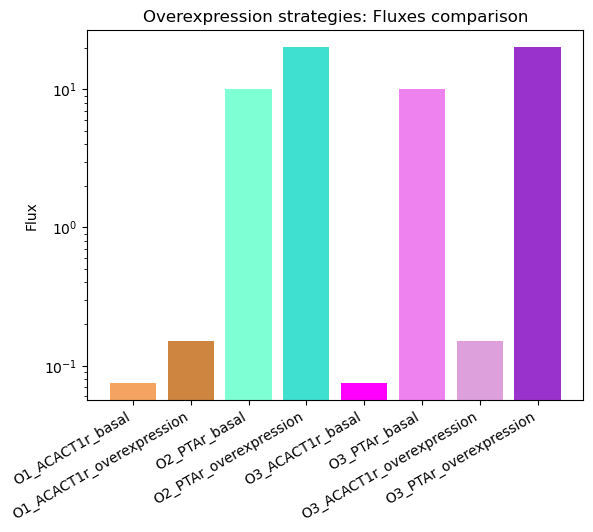

In [131]:
Overexpressions = ["O1_ACACT1r_basal", "O1_ACACT1r_overexpression", "O2_PTAr_basal", "O2_PTAr_overexpression", "O3_ACACT1r_basal", "O3_PTAr_basal", "O3_ACACT1r_overexpression", "O3_PTAr_overexpression"]
Fluxes = [O1_ACACT1r_basal, O1_ACACT1r_overexpression, O2_PTAr_basal, O2_PTAr_overexpression, O3_ACACT1r_basal, O3_PTAr_basal, O3_ACACT1r_overexpression, O3_PTAr_overexpression]
colors = ('sandybrown','peru','aquamarine','turquoise', 'magenta', 'violet', 'plum', 'darkorchid')

plt.bar(Overexpressions, Fluxes, color=colors)
plt.yscale('log')

plt.ylabel('Flux')
plt.title('Overexpression strategies: Fluxes comparison')
x_positions = range(len(Overexpressions))
plt.xticks(x_positions, Overexpressions, rotation=30, ha='right')

plt.show()

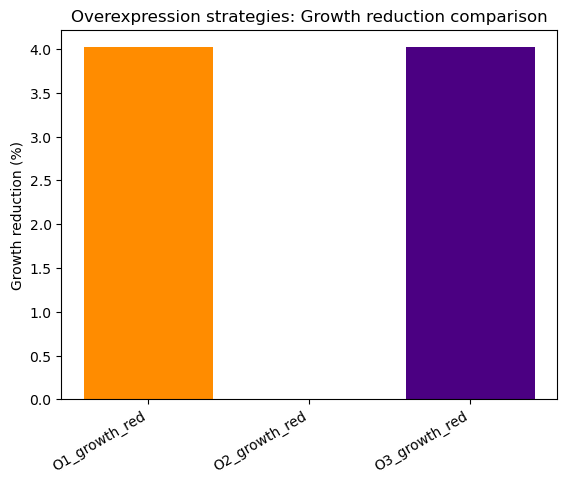

In [132]:
Overexpressions = ["O1_growth_red", "O2_growth_red", "O3_growth_red"]
Growth_reds = [O1_growth_red, O2_growth_red, O3_growth_red]
colors = ('darkorange', 'lightseagreen', 'indigo')

plt.bar(Overexpressions, Growth_reds, color=colors)

plt.ylabel('Growth reduction (%)')
plt.title('Overexpression strategies: Growth reduction comparison')
x_positions = range(len(Overexpressions))
plt.xticks(x_positions, Overexpressions, rotation=30, ha='right')

plt.show()

As these are mathemathical models, basically when you combine overexpressions you just get an addition of consequences. You would think this is nice, but is extremely far from reality.

Therefore, we'll ignore the overexpression combination for now. From the single overexpression strategies, we would first go for acetate uptake overexpression since we get less growth reduction with the same increase (2-fold) in fluxes.